In [21]:
import pandas as pd
from sklearn.metrics import precision_recall_curve, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from typing import Tuple
import numpy as np
import matplotlib.pyplot 

In [3]:
df = pd.read_csv('../data/feature_frames.csv')

In [4]:
df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [30]:
info_cols = ['variant_id', 'order_id', 'user_id', 'created_at', 'order_date']
label_col = 'outcome'
features_cols = [col for col in df.columns if col not in info_cols + [label_col]]

categorical_cols = ['product_type', 'vendor']
binary_cols = ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']
numerical_cols = [col for col in features_cols if col not in categorical_cols + binary_cols]


In [7]:
def push_relevant_dataframe(df: pd.DataFrame, min_products: int=5) -> pd.DataFrame:
    """ We are only interested in big enough orders that are profitable """
    order_size = df.groupby('order_id').outcome.sum()
    orders_of_min_size = order_size[order_size >= min_products].index
    return df.loc[lambda x: x.order_id.isin(orders_of_min_size)]

df_selected = (
    df
    .pipe(push_relevant_dataframe)
    .assign(created_at=lambda x: pd.to_datetime(x.created_at))
    .assign(order_date=lambda x: pd.to_datetime(x.order_date).dt.date)
)


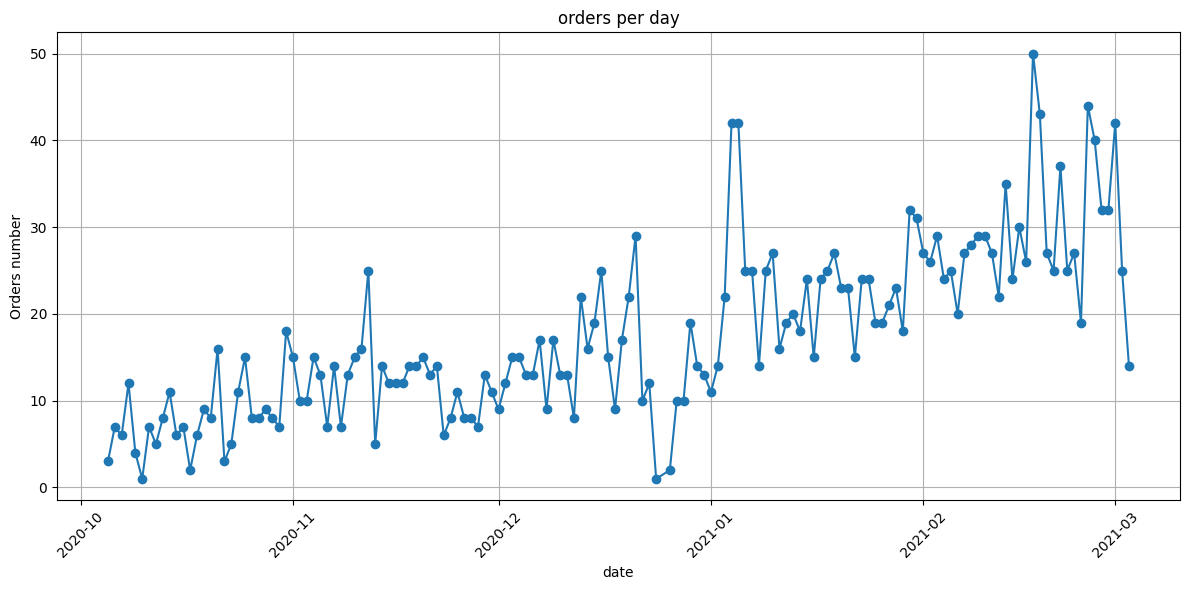

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

orders_per_day = df_selected.groupby(df_selected['created_at'].dt.date)['order_id'].nunique()

plt.figure(figsize=(12, 6))
orders_per_day.plot(kind='line', marker='o')

plt.title('orders per day')
plt.xlabel('date')
plt.ylabel('Orders number')
plt.grid(True)
plt.xticks(rotation=45) 
plt.tight_layout()

plt.show()


# Splits

In [24]:
percentage_orders_by_date = orders_per_day.cumsum() / orders_per_day.sum()

train_val_cutoff = percentage_orders_by_date[percentage_orders_by_date <= 0.7].idxmax()
val_test_cutoff = percentage_orders_by_date[percentage_orders_by_date <= 0.9].idxmax()

print("Train since:", percentage_orders_by_date.index.min())
print("Train until:", train_val_cutoff)
print("Val until:", val_test_cutoff)
print("Test until:", percentage_orders_by_date.index.max())


Train since: 2020-10-05
Train until: 2021-02-04
Val until: 2021-02-22
Test until: 2021-03-03


In [25]:
train_df = df_selected[df_selected.order_date <= train_val_cutoff]
val_df = df_selected[(df_selected.order_date > train_val_cutoff) & (df_selected.order_date <= val_test_cutoff)]
test_df = df_selected[df_selected.order_date > val_test_cutoff]


In [28]:
def feature_label_split(df: pd.DataFrame, label_col: str) -> (pd.DataFrame, pd.Series):
    return df.drop(label_col, axis=1), df[label_col]

X_train, y_train = feature_label_split(train_df, label_col)
X_val, y_val = feature_label_split(val_df, label_col)
X_test, y_test = feature_label_split(test_df, label_col)


In [22]:


def plot_metrics(
    model_name: str, y_pred: pd.Series, y_test: pd.Series, 
    target_precision: float = 0.05, 
    figure: Tuple[plt.Figure, np.ndarray] = None
):
    precision_, recall_, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall_, precision_)

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    if figure is None:
        fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    else:
        fig, ax = figure

    ax[0].plot(recall_, precision_, label=f"{model_name}; AUC: {pr_auc:.2f}")
    ax[0].set_xlabel("recall")
    ax[0].set_ylabel("precision")
    ax[0].set_title("Precision-recall Curve")
    ax[0].legend()

    ax[1].plot(fpr, tpr, label=f"AUC: {roc_auc:.2f}")
    ax[1].set_xlabel("FPR")
    ax[1].set_ylabel("TPR")
    ax[1].set_title("ROC Curve")
    ax[1].legend()

    return fig, ax



# Baseline

(<Figure size 1400x700 with 2 Axes>,
 array([<Axes: title={'center': 'Precision-recall Curve'}, xlabel='recall', ylabel='precision'>,
        <Axes: title={'center': 'ROC Curve'}, xlabel='FPR', ylabel='TPR'>],
       dtype=object))

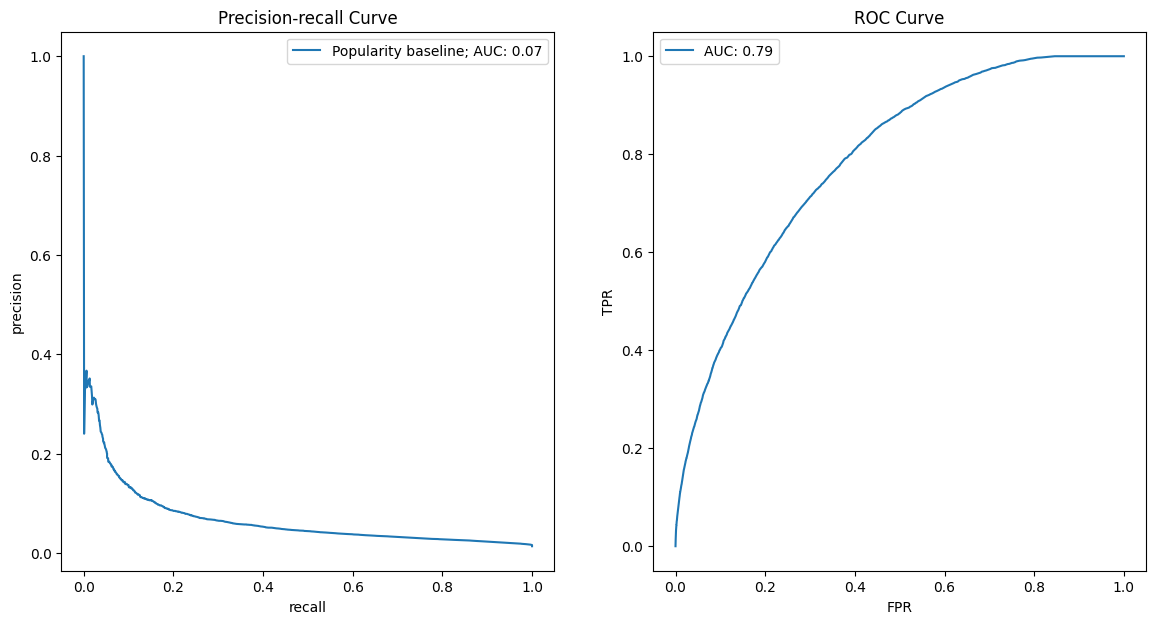

In [26]:
plot_metrics("Popularity baseline", y_pred=val_df["global_popularity"], y_test=val_df[label_col])

# Modeling

### Excluding categorical cols

In [ ]:
train_cols = numerical_cols + binary_cols

##### Without CV

###### Random Forest

KeyboardInterrupt: 

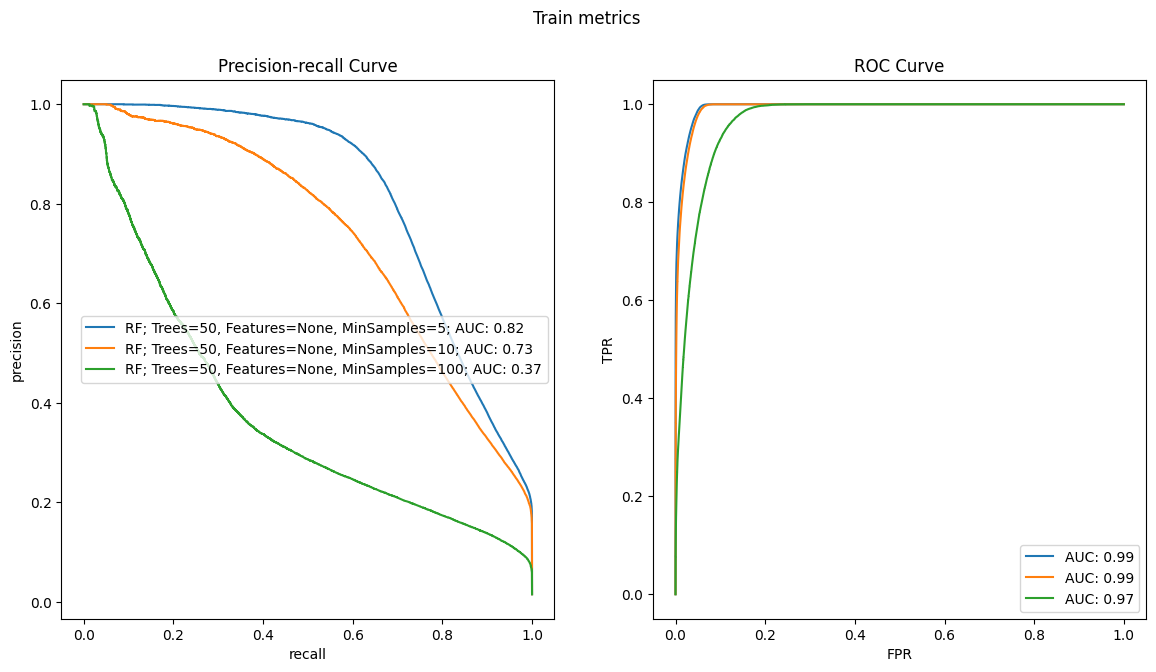

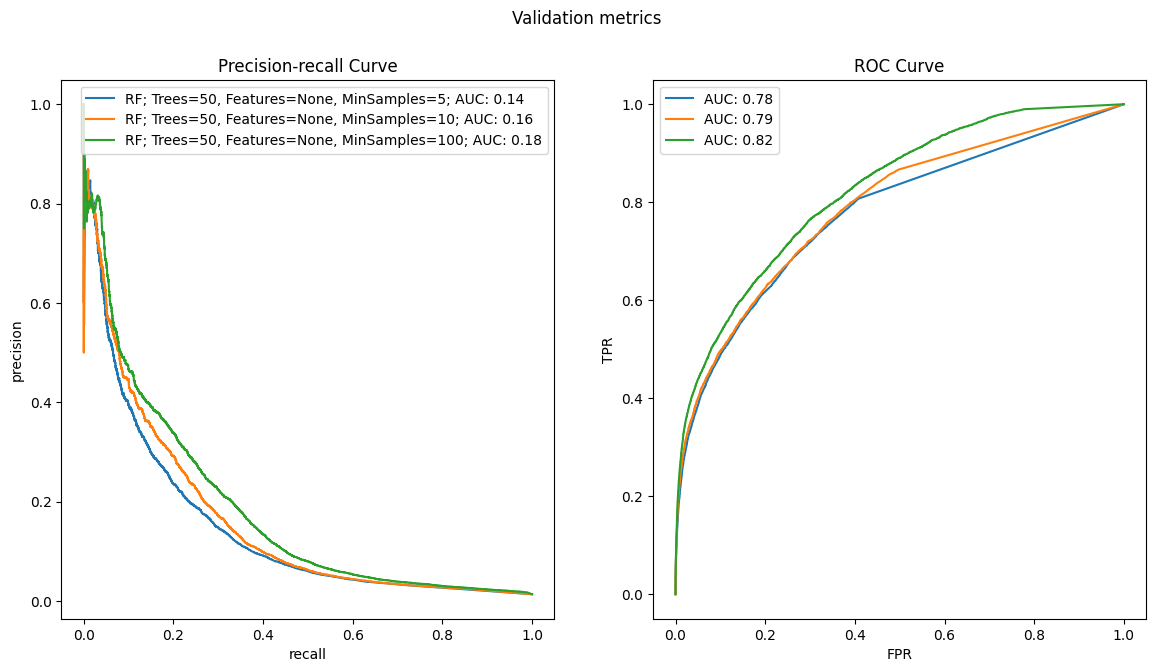

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


fig1, ax1 = plt.subplots(1, 2, figsize=(14, 7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize=(14, 7))
fig2.suptitle("Validation metrics")

# Hyperparameters
n_estimators = [50, 100, 200, 500]
max_features = [ None]  
min_samples_split = [5,10,100,500]


for trees in n_estimators:
    for features in max_features:
        for min_samples in min_samples_split:
            rf = make_pipeline(
                StandardScaler(),
                RandomForestClassifier(n_estimators=trees, max_features=features, min_samples_split=min_samples)
            )
            rf.fit(X_train[train_cols], y_train)
            train_proba = rf.predict_proba(X_train[train_cols])[:, 1]
            plot_metrics(f"RF; Trees={trees}, Features={features}, MinSamples={min_samples}",
                         y_pred=train_proba, y_test=train_df[label_col], figure=(fig1, ax1))
            
            val_proba = rf.predict_proba(X_val[train_cols])[:, 1]
            plot_metrics(f"RF; Trees={trees}, Features={features}, MinSamples={min_samples}",
                         y_pred=val_proba, y_test=val_df[label_col], figure=(fig2, ax2))

# Baseline
plot_metrics(f"Baseline", y_pred=val_df['global_popularity'], y_test=val_df[label_col], figure=(fig2, ax2))


###### Gradient Boosting Trees

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


fig1, ax1 = plt.subplots(1, 2, figsize=(14, 7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize=(14, 7))
fig2.suptitle("Validation metrics")


n_estimators = [100, 200, 300, 400] 
learning_rate = [0.01, 0.1, 0.2, 0.3]  
max_depth = [3, 5, 7, 9]  
min_samples_split = [2, 4, 6, 8]

for trees in n_estimators:
    for rate in learning_rate:
        for depth in max_depth:
            for min_samples in min_samples_split:
                gbt = make_pipeline(
                    StandardScaler(),
                    GradientBoostingClassifier(
                        n_estimators=trees,
                        learning_rate=rate,
                        max_depth=depth,
                        min_samples_split=min_samples
                    )
                )
                gbt.fit(X_train[train_cols], y_train)
                train_proba = gbt.predict_proba(X_train[train_cols])[:, 1]
                plot_metrics(f"GBT; Trees={trees}, Rate={rate}, Depth={depth}, MinSamples={min_samples}",
                             y_pred=train_proba, y_test=train_df[label_col], figure=(fig1, ax1))
                
                val_proba = gbt.predict_proba(X_val[train_cols])[:, 1]
                plot_metrics(f"GBT; Trees={trees}, Rate={rate}, Depth={depth}, MinSamples={min_samples}",
                             y_pred=val_proba, y_test=val_df[label_col], figure=(fig2, ax2))

# Baseline
plot_metrics(f"Baseline", y_pred=val_df['global_popularity'], y_test=val_df[label_col], figure=(fig2, ax2))

##### With CV

### Including categorical cols